# Air quality forecasting

## Setup

In [50]:
import os
import datetime
import re
import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import missingno as msno
import tensorflow as tf
from sklearn.impute import SimpleImputer

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [51]:
print(tf.version.VERSION)

2.3.0


## User Defined Functions 

In [52]:
def plot_pm10(data):
    plot_cols = ['PM10']
    plot_features = data[plot_cols]
    plot_features.index = date_time
    _ = plot_features.plot(subplots=True)

    plot_features = data[plot_cols][:480]
    plot_features.index = date_time[:480]
    _ = plot_features.plot(subplots=True)
    
def data_split(df):
    column_indices = {name: i for i, name in enumerate(df.columns)}
    n = len(df)
    train_df = df[0:int(n*0.7)]
    val_df = df[int(n*0.7):int(n*0.85)]
    test_df = df[int(n*0.85):]
    num_features = df.shape[1]
    return train_df,val_df,test_df

## Air Pollution dataset

In [53]:
df = pd.read_csv(r'air_dataframe_Univariate.csv',sep=',')# loading the data
df["Start"]=pd.to_datetime(df["Start"])
date_time = pd.to_datetime(df.pop('Start'), format='%d.%m.%Y %H:%M:%S')

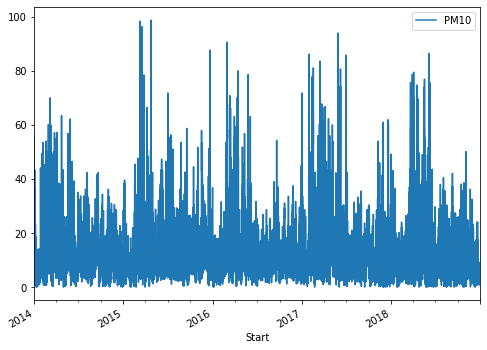

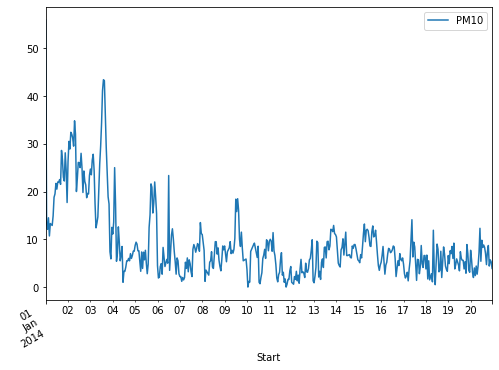

In [54]:
plot_pm10(df)

## 1. Inspect and cleanup

In [55]:
print('Missing PM10 Value:',df['PM10'].isnull().sum())

Missing PM10 Value: 0


## 2. Model

In [56]:
CONV_WIDTH = 3
MAX_EPOCHS = 20
def model(df):
    
    #Split data
    train_df,val_df,test_df = data_split(df)
    num_features = df.shape[1]
    column_indices = {name: i for i, name in enumerate(df.columns)}
    
    #Normalize data
    train_mean = train_df.mean()
    train_std = train_df.std()
    train_df= (train_df - train_mean) / train_std
    val_df= (val_df - train_mean) / train_std
    test_df= (test_df - train_mean) / train_std
    
    
    #Indexes and offsets
    class WindowGenerator():
        def __init__(self, input_width, label_width, shift,train_df=train_df, val_df=val_df, test_df=test_df,label_columns=None):
            # Store the raw data.
            self.train_df = train_df
            self.val_df = val_df
            self.test_df = test_df

            # Work out the label column indices.
            self.label_columns = label_columns
            if label_columns is not None:
                self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
            self.column_indices = {name: i for i, name in
                                   enumerate(train_df.columns)}

            # Work out the window parameters.
            self.input_width = input_width
            self.label_width = label_width
            self.shift = shift

            self.total_window_size = input_width + shift

            self.input_slice = slice(0, input_width)
            self.input_indices = np.arange(self.total_window_size)[self.input_slice]

            self.label_start = self.total_window_size - self.label_width
            self.labels_slice = slice(self.label_start, None)
            self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

        def __repr__(self):
            return '\n'.join([
                f'Total window size: {self.total_window_size}',
                f'Input indices: {self.input_indices}',
                f'Label indices: {self.label_indices}',
                f'Label column name(s): {self.label_columns}'])
    w2 = WindowGenerator(input_width=48, label_width=24, shift=1,
                         label_columns=['PM10'])
    
    #Split
    def split_window(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
            [labels[:, :, self.column_indices[name]] for name in self.label_columns],
            axis=-1)
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])
        return inputs, labels
    WindowGenerator.split_window = split_window
    
    #Plot
    def plot(self, model=None, plot_col='PM10', max_subplots=1):
        inputs, labels = self.example
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        for n in range(max_n):
            plt.subplot(3, 1, n+1)
            plt.ylabel(f'{plot_col} [normed]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],label='Inputs', marker='.', zorder=-10)

            if self.label_columns:
                label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
                label_col_index = plot_col_index

            if label_col_index is None:
                continue

            plt.scatter(self.label_indices, labels[n, :, label_col_index],edgecolors='k', label='Labels', c='#2ca02c', s=64)

            if model is not None:
                predictions = model(inputs)
                plt.scatter(self.label_indices, predictions[n, :, label_col_index],marker='X', edgecolors='k', label='Predictions', c='#ff7f0e', s=64)

            if n == 0:
                plt.legend()

        plt.xlabel('Time [h]')
    WindowGenerator.plot = plot
    
    #Create tf.data.Datasets
    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=True,
            batch_size=32,)

        ds = ds.map(self.split_window)

        return ds

    WindowGenerator.make_dataset = make_dataset

    @property
    def train(self):
        return self.make_dataset(self.train_df)

    @property
    def val(self):
        return self.make_dataset(self.val_df)

    @property
    def test(self):
        return self.make_dataset(self.test_df)

    @property
    def example(self):
        result = getattr(self, '_example', None)
        if result is None:
            # No example batch was found, so get one from the `.train` dataset
            result = next(iter(self.train))
            # And cache it for next time
            self._example = result
        return result

    WindowGenerator.train = train
    WindowGenerator.val = val
    WindowGenerator.test = test
    WindowGenerator.example = example
    
    #Compile model
    def compile_and_fit(model, window, patience=2):
        early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                        patience=patience,
                                                        mode='min')

        model.compile(loss=tf.losses.MeanSquaredError(),
                    optimizer=tf.optimizers.Adam(),
                    metrics=[tf.metrics.MeanAbsoluteError()])

        history = model.fit(window.train, epochs=MAX_EPOCHS,
                          validation_data=window.val,callbacks=[early_stopping])
        return history
    
    #Plot Training and Validation loss against EPOCH
    def loss_plot(history):
        hist = pd.DataFrame(history.history)
        hist['epoch'] = history.epoch
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'validation'], loc='upper left')
        plt.figure(0)
        plt.show()
    
    #Windows
    single_step_window = WindowGenerator(
    input_width=1, 
    label_width=1, 
    shift=1,
    label_columns=['PM10'])
    
    wide_window = WindowGenerator(
    input_width=24, 
    label_width=24, 
    shift=1,
    label_columns=['PM10'])
    
    conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=['PM10'])
    
    LABEL_WIDTH = 24
    INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
    wide_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=['PM10'])
    

    #Baseline Method
    print('\nBaseline Approach:')
    class Baseline(tf.keras.Model):
        def __init__(self, label_index=None):
            super().__init__()
            self.label_index = label_index

        def call(self, inputs):
            if self.label_index is None:
                return inputs
            result = inputs[:, :, self.label_index]
            return result[:, :, tf.newaxis]
    baseline = Baseline(label_index=column_indices['PM10'])

    baseline.compile(loss=tf.losses.MeanSquaredError(),
                     metrics=[tf.metrics.MeanAbsoluteError()])
    val_performance = {}
    performance = {}
    val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
    performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)
    wide_window.plot(baseline)
    print('----------------------------------------------')

    #LSTM
    print('\nLSTM Approach:')
    lstm_model = tf.keras.models.Sequential([
        tf.keras.layers.LSTM(32, return_sequences=True),
        tf.keras.layers.Dense(units=1)
    ])
    history = compile_and_fit(lstm_model, wide_window)
    val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
    performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)
    wide_window.plot(lstm_model)
    #loss_plot(history)
    print('----------------------------------------------')
    
    #Performance
    print('\nPerformance Matrix:')
    x = np.arange(len(performance))
    width = 0.3
    metric_name = 'mean_absolute_error'
    metric_index = lstm_model.metrics_names.index('mean_absolute_error')
    val_mae = [v[metric_index] for v in val_performance.values()]
    test_mae = [v[metric_index] for v in performance.values()]
    plt.figure(0)
    plt.ylabel('mean_absolute_error [PM10, normalized]')
    plt.bar(x - 0.17, val_mae, width, label='Validation')
    plt.bar(x + 0.17, test_mae, width, label='Test')
    plt.xticks(ticks=x, labels=performance.keys(),
               rotation=45)
    _ = plt.legend()

    for name, value in performance.items():
        print(f'{name:12s}: {value[1]:0.4f}')
    print('----------------------------------------------')
    


Baseline Approach:
206/206 [==============================] - 1s 3ms/step - loss: 0.2128 - mean_absolute_error: 0.2400
----------------------------------------------

LSTM Approach:
Epoch 1/20
958/958 [==============================] - 13s 13ms/step - loss: 0.2846 - mean_absolute_error: 0.3371 - val_loss: 0.1803 - val_mean_absolute_error: 0.2374
Epoch 2/20
958/958 [==============================] - 13s 13ms/step - loss: 0.2205 - mean_absolute_error: 0.2906 - val_loss: 0.1765 - val_mean_absolute_error: 0.2341
Epoch 3/20
958/958 [==============================] - 13s 13ms/step - loss: 0.2155 - mean_absolute_error: 0.2885 - val_loss: 0.1745 - val_mean_absolute_error: 0.2295
Epoch 4/20
958/958 [==============================] - 13s 13ms/step - loss: 0.2116 - mean_absolute_error: 0.2873 - val_loss: 0.1756 - val_mean_absolute_error: 0.2333
Epoch 5/20
205/205 [==============================] - 1s 5ms/step - loss: 0.1763 - mean_absolute_error: 0.2322
------------------------------------------

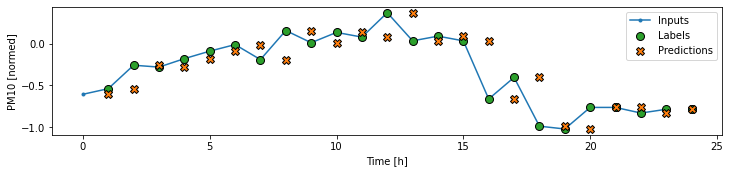

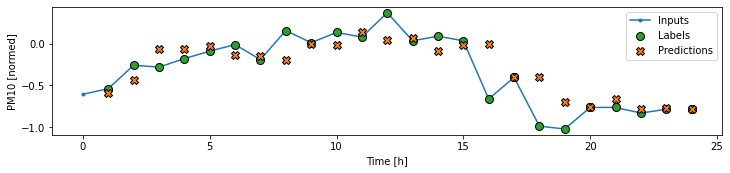

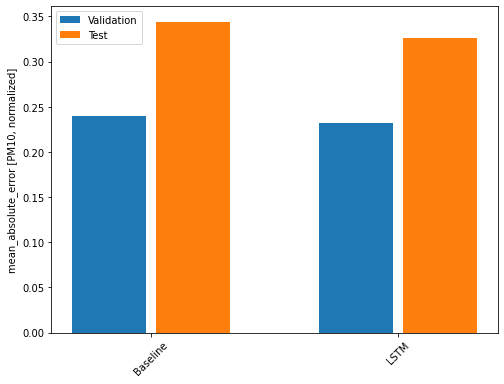

In [57]:
model(df)